In [1]:
# Libraries

import json
import numpy
import os
import shutil
import sys

In [2]:
# Root directory

ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tune

from ray.air                  import RunConfig
from ray.tune                 import JupyterNotebookReporter
from ray.tune                 import TuneConfig
from ray.tune                 import Tuner
from ray.tune.logger          import CSVLoggerCallback
from ray.tune.schedulers      import ASHAScheduler
from ray.tune.search          import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch

from ray import tune

In [4]:
# Code

from src.cnn import raytune as cnn_raytune
from src.cnn import core    as cnn_core
from src.io  import loader  as data_loader

# 1. Setup

In [5]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'out', 'nbp06-tuner', 'zrimec2020')
RES = os.path.join(CWD, 'res', 'plant')

OUT_DATA = os.path.join(OUT, '')
OUT_PLOT = os.path.join(OUT, 'plot')
OUT_LOG  = os.path.join(OUT, 'log')

RES_NBP04 = os.path.join(CWD, 'out', 'nbp04-feature')
RES_NBP05 = os.path.join(CWD, 'out', 'nbp05-target')

shutil.rmtree(OUT, ignore_errors = True)

os.makedirs(OUT,      exist_ok = True)
os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out\nbp06-tuner\zrimec2020
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res\plant


In [6]:
# Load the inputs and ouputs

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

In [7]:
# Lock random

RANDOM_SEED = cnn_core.lock_random(
	generate_seed = True
)

print('Random seed : {}'.format(RANDOM_SEED))

Random seed : 808087171


In [8]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

print(json.dumps(SYSTEM, indent = '\t'))

{
	"platform_python": "3.10.7",
	"platform_system": "Windows",
	"platform_release": "10",
	"platform_version": "10.0.19044",
	"cpu_name": "N/A",
	"cpu_count": 12,
	"cuda_name": "NVIDIA GeForce RTX 3060 Ti",
	"cuda_available": true,
	"cuda_devices": 1,
	"memory_total": "31.924 GB",
	"memory_available": "22.962 GB"
}


# 2. CNN Regression

## 2.1 Config

In [9]:
# Define basic data parameters

core_config = {
	'random_seed' : RANDOM_SEED,
	'device'      : DEVICE,
	'model_name'  : OUT.split(os.sep)[-1] + 'r',
	'epochs'      : 10,
	'expand_dims' : None,

	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	},
	'files' : {
		'sequences' : lambda : data_loader.load_fasta(filename = os.path.join(RES_NBP04, 'features-bp2150.fasta'), to_string = True),
		'frequency' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-frequency.npz')),
		'stability' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-stability.npz')),
		'values'    : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-values.json'), to_numpy = True),
		'order'     : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-order.json'))
	}
}

In [10]:
# Ensure correct

core_config['output']['length'] = len(tpm_order[core_config['output']['group0']])

if core_config['model_name'].startswith('washburn2019') :
	core_config['expand_dims'] = 0

## 2.2 Search Space

In [11]:
# Define optimizer parameters

optimizer_name     = tune.choice(['adam', 'sgd'])
optimizer_lr       = tune.loguniform(1e-5, 1e-2)
optimizer_decay    = tune.uniform(0.0, 0.10)
optimizer_momentum = tune.uniform(0.0, 0.99)

In [12]:
# Define scheduler parameters

scheduler_name             = tune.choice(['constant', 'step', 'plateau', 'linear', 'exponential'])
scheduler_plateau_factor   = tune.uniform(0.1, 0.5)
scheduler_plateau_patience = tune.randint(1, 20)
scheduler_step_factor      = tune.uniform(0.1, 0.5)
scheduler_step_patience    = tune.randint(1, 20)
scheduler_linear_factor    = tune.uniform(1e-05, 1e-01)
scheduler_exp_factor       = tune.uniform(0.950, 0.999)

In [13]:
# Define model parameters

model_dropout  = tune.quniform(0.0, 0.5, 0.01)

conv1_kernels  = [5, 11, 21, 31, 41]
conv1_filters  = [32, 64, 128, 256]

convx_kernels  = [5, 11, 21, 31, 41]
convx_padding  = ['same', 'none']
convx_filters  = [32, 64, 128, 256]
convx_dilation = [1, 2, 4]

poolx_kernels  = [3, 5, 9]
poolx_padding  = ['same', 'none']

fcx_features = [64, 128, 256, 512]

if core_config['model_name'].startswith('washburn2019') :
	conv1_kernels = [(4, x) for x in conv1_kernels]
	convx_kernels = [(1, x) for x in convx_kernels]
	poolx_kernels = [(1, x) for x in poolx_kernels]

In [14]:
# Define search space (tested with zrimec2020 and washburn2019)

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = tune.choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']     = optimizer_name
param_space['optimizer/lr']       = optimizer_lr
param_space['optimizer/decay']    = optimizer_decay
param_space['optimizer/momentum'] = optimizer_momentum

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/plateau/factor']     = scheduler_plateau_factor
param_space['scheduler/plateau/patience']   = scheduler_plateau_patience
param_space['scheduler/linear/factor']      = scheduler_linear_factor
param_space['scheduler/step/factor']        = scheduler_step_factor
param_space['scheduler/step/patience']      = scheduler_step_patience
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout'] = model_dropout

# Convolution
param_space['model/conv1/filters']  = tune.choice(conv1_filters)
param_space['model/conv1/kernel']   = tune.choice(conv1_kernels)
param_space['model/conv1/padding']  = 'none'
param_space['model/conv1/dilation'] = 1
param_space['model/conv2/filters']  = tune.choice(convx_filters)
param_space['model/conv2/kernel']   = tune.choice(convx_kernels)
param_space['model/conv2/padding']  = tune.choice(convx_padding)
param_space['model/conv2/dilation'] = 1
param_space['model/conv3/filters']  = tune.choice(convx_filters)
param_space['model/conv3/kernel']   = tune.choice(convx_kernels)
param_space['model/conv3/padding']  = tune.choice(convx_padding)
param_space['model/conv3/dilation'] = 1

if core_config['model_name'].startswith('washburn2019') :
	param_space['model/conv4/filters']  = tune.choice(convx_filters)
	param_space['model/conv4/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv4/padding']  = tune.choice(convx_padding)
	param_space['model/conv4/dilation'] = 1
	param_space['model/conv5/filters']  = tune.choice(convx_filters)
	param_space['model/conv5/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv5/padding']  = tune.choice(convx_padding)
	param_space['model/conv5/dilation'] = 1
	param_space['model/conv6/filters']  = tune.choice(convx_filters)
	param_space['model/conv6/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv6/padding']  = tune.choice(convx_padding)
	param_space['model/conv6/dilation'] = 1

# Pooling
param_space['model/maxpool1/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool1/padding'] = 'same'
param_space['model/maxpool2/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool2/padding'] = 'same'
param_space['model/maxpool3/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool3/padding'] = 'same'

# Linear
param_space['model/fc1/features'] = tune.choice(fcx_features)
param_space['model/fc2/features'] = tune.choice(fcx_features)

In [15]:
# Define starting parameters for algorithm (some decent starting point from previous runs)

params_initial = None

if core_config['model_name'].startswith('zrimec2020') :
	params_initial = [{
		'dataset/batch_size'           : 32,
		'optimizer/name'               : 'adam',
		'optimizer/lr'                 : 1e-4,
		'optimizer/decay'              : 0.1,
		'optimizer/momentum'           : 0.99,
		'scheduler/name'               : 'plateau',
		'scheduler/plateau/factor'     : 0.5,
		'scheduler/plateau/patience'   : 5,
		'scheduler/step/factor'        : 0.5,
		'scheduler/step/patience'      : 5,
		'scheduler/linear/factor'      : 1e-3,
		'scheduler/exponential/factor' : 0.98,
		'model/dropout'                : 0.1,
		'model/conv1/filters'          : 32,
		'model/conv1/kernel'           : 21,
		'model/conv1/padding'          : 0,
		'model/conv1/dilation'         : 1,
		'model/conv1/padding'          : 'none',
		'model/conv2/filters'          : 256,
		'model/conv2/kernel'           : 31,
		'model/conv2/dilation'         : 1,
		'model/conv2/padding'          : 'same',
		'model/conv3/filters'          : 256,
		'model/conv3/kernel'           : 31,
		'model/conv3/padding'          : 'same',
		'model/conv3/dilation'         : 1,
		'model/maxpool1/kernel'        : 3,
		'model/maxpool1/padding'       : 'same',
		'model/maxpool2/kernel'        : 9,
		'model/maxpool2/padding'       : 'same',
		'model/maxpool3/kernel'        : 3,
		'model/maxpool3/padding'       : 'same',
		'model/fc1/features'           : 256,
		'model/fc2/features'           : 128
	}]

## 2.3 Tuning

In [16]:
# Create a tune method

tune_method = tune.with_resources(
	lambda x : cnn_raytune.tune_method(
		tune_config = x,
		core_config = core_config
	),
	{
		'cpu' : max(1, SYSTEM['cpu_count'] // 2),
		'gpu' : max(0, SYSTEM['cuda_devices'])
	}
)

In [17]:
# Create tune config

tune_searcher = HyperOptSearch(
	points_to_evaluate = params_initial,
	metric             = 'valid_loss',
	mode               = 'min'
)

tune_searcher = ConcurrencyLimiter(
	tune_searcher,
	max_concurrent = 1
)

tune_scheduler = ASHAScheduler(
	time_attr        = 'training_iteration',
	max_t            = 100,
	grace_period     = 2,
	reduction_factor = 4,
	brackets         = 1
)

tune_config = TuneConfig(
	metric      = 'valid_loss',
	mode        = 'min',
	num_samples = 20,
	search_alg  = tune_searcher,
	scheduler   = tune_scheduler,
	trial_name_creator    = lambda x : str(x.trial_id),
	trial_dirname_creator = lambda x : str(x.trial_id)
)

In [18]:
# Create tune run config

VERBOSE_SILENT = 0
VERBOSE_STATUS = 1
VERBOSE_BRIEF  = 2
VERBOSE_DETAIL = 3

reporter = JupyterNotebookReporter(
	max_column_length = 32,
	max_progress_rows = 20,
	parameter_columns = ['dataset/batch_size', 'optimizer/name', 'optimizer/lr', 'scheduler/name'],
	metric_columns    = ['valid_loss', 'valid_r2', 'train_loss']
)

run_config = RunConfig(
	name              = 'raytune',
	local_dir         = OUT_DATA,
	callbacks         = None,
	log_to_file       = True,
	verbose           = VERBOSE_STATUS,
	progress_reporter = reporter
)

In [19]:
# Create tune and fit

tuner = Tuner(
	trainable   = tune_method,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-02-06 15:19:59,090	INFO worker.py:1538 -- Started a local Ray instance.
2023-02-06 17:15:38,935	INFO tune.py:762 -- Total run time: 6938.56 seconds (6938.14 seconds for the tuning loop).


## 2.4 Reports

In [20]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [21]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	if column.startswith('config/') :
		column = column[7:]

	print('{:>32s}, '.format(column), end = '')

	if index % 5 == 0 and index > 0 :
		print()

                      valid_loss,                         valid_r2,                        valid_mae,                       train_loss,                 time_this_iter_s, 
               should_checkpoint,                             done,                  timesteps_total,                   episodes_total,               training_iteration, 
                        trial_id,                    experiment_id,                             date,                        timestamp,                     time_total_s, 
                             pid,                         hostname,                          node_ip,               time_since_restore,          timesteps_since_restore, 
        iterations_since_restore,                      warmup_time,               dataset/batch_size,             model/conv1/dilation,              model/conv1/filters, 
              model/conv1/kernel,              model/conv1/padding,             model/conv2/dilation,              model/conv2/filters,          

In [22]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min() / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max() / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum() / 60.0))
print()

trials = dataframe[['trial_id', 'logdir', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      1.2 minutes
 Longest training time :     33.1 minutes
   Total training time :    114.1 minutes



,trial_id,logdir,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
8,7bf46775,C:\Developer\Workspace\PyCharm\Projects\upolan...,191.897,10,0.582,0.069,0.631,0.474
18,51b20ffa,C:\Developer\Workspace\PyCharm\Projects\upolan...,567.518,8,0.588,0.089,0.628,0.442
7,e130ec3d,C:\Developer\Workspace\PyCharm\Projects\upolan...,1985.264,8,0.590,0.079,0.646,0.572
0,60138f8c,C:\Developer\Workspace\PyCharm\Projects\upolan...,1489.456,10,0.605,0.026,0.631,0.391
6,cf13a8c1,C:\Developer\Workspace\PyCharm\Projects\upolan...,549.330,10,0.636,0.002,0.659,0.583
9,b74d8630,C:\Developer\Workspace\PyCharm\Projects\upolan...,185.100,2,0.718,-0.140,0.702,0.732
5,6803918f,C:\Developer\Workspace\PyCharm\Projects\upolan...,121.140,8,0.753,-0.168,0.707,0.628
15,9f21265d,C:\Developer\Workspace\PyCharm\Projects\upolan...,70.185,2,0.967,-0.556,0.791,0.765
4,3dca014a,C:\Developer\Workspace\PyCharm\Projects\upolan...,167.022,8,0.989,-0.553,0.800,0.628
11,f93a3252,C:\Developer\Workspace\PyCharm\Projects\upolan...,74.432,2,1.114,-0.790,0.853,1.412


### 2.4.1 VIsualization

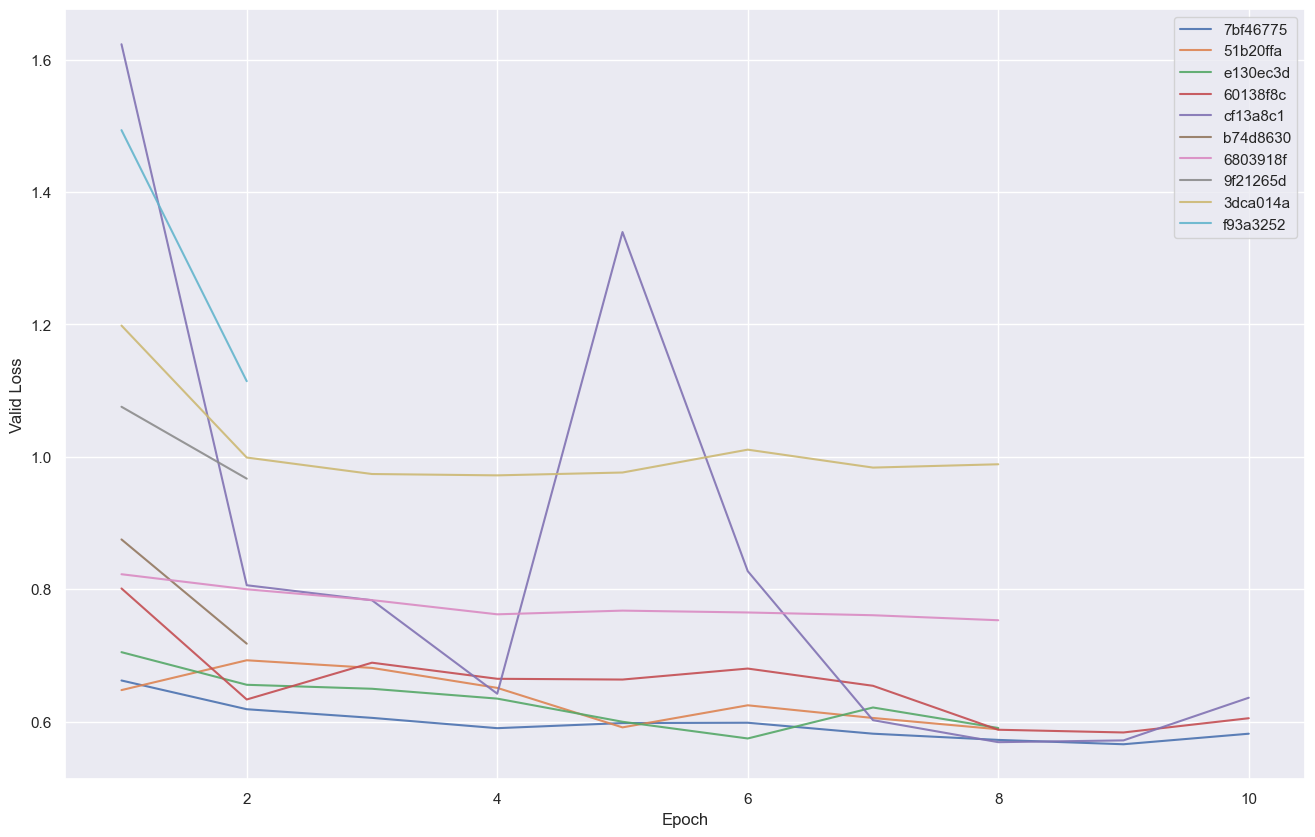

In [23]:
# Plot trials valid loss

cnn_raytune.plot_trials_loss(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, core_config['model_name'] + '-trials')
)

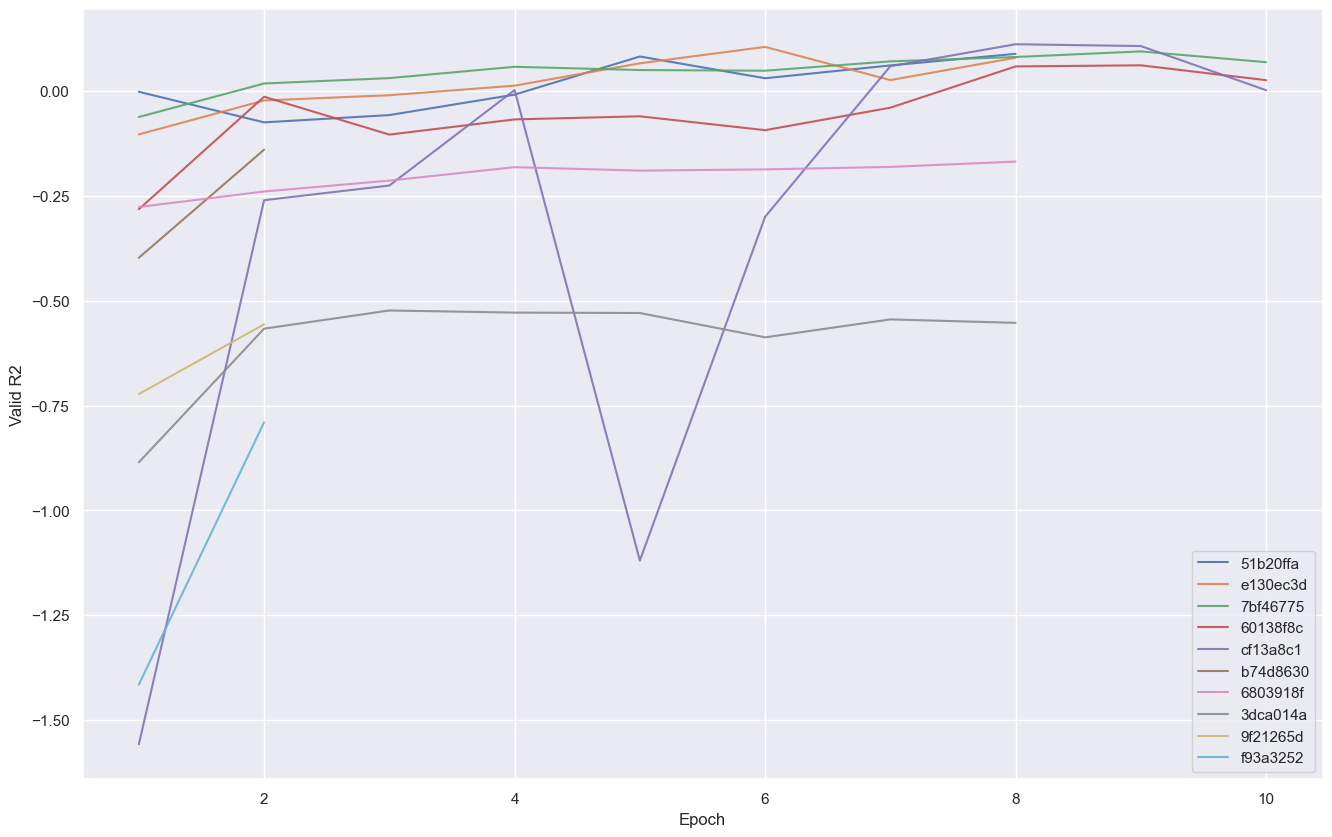

In [24]:
# Plot trials valid r2

cnn_raytune.plot_trials_r2(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, core_config['model_name'] + '-trials')
)

### 2.4.2 Best

In [25]:
# Display best trial

best = report.get_best_result()

print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))
print('Best config : ')
print(json.dumps(best.config, indent = '\t'))

Best metric : loss =  0.58158 r2 =  0.06863
Best config : 
{
	"dataset/batch_size": 32,
	"optimizer/name": "adam",
	"optimizer/lr": 3.262648825129617e-05,
	"optimizer/decay": 0.05530820765433695,
	"optimizer/momentum": 0.5857655085105684,
	"scheduler/name": "constant",
	"scheduler/plateau/factor": 0.3798409889797759,
	"scheduler/plateau/patience": 4,
	"scheduler/linear/factor": 0.004318109387491916,
	"scheduler/step/factor": 0.16975929027771253,
	"scheduler/step/patience": 11,
	"scheduler/exponential/factor": 0.9652544464799763,
	"model/dropout": 0.02,
	"model/conv1/filters": 32,
	"model/conv1/kernel": 11,
	"model/conv1/padding": "none",
	"model/conv1/dilation": 1,
	"model/conv2/filters": 32,
	"model/conv2/kernel": 31,
	"model/conv2/padding": "same",
	"model/conv2/dilation": 1,
	"model/conv3/filters": 64,
	"model/conv3/kernel": 41,
	"model/conv3/padding": "none",
	"model/conv3/dilation": 1,
	"model/maxpool1/kernel": 5,
	"model/maxpool1/padding": "same",
	"model/maxpool2/kernel": 3,
	"m

In [26]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,7bf46775,1f4d13e364cc4de48d28f8ab29884495,54.532,1,0.662,-0.062,0.676,1.065
1,7bf46775,1f4d13e364cc4de48d28f8ab29884495,69.748,2,0.619,0.018,0.657,0.658
2,7bf46775,1f4d13e364cc4de48d28f8ab29884495,84.878,3,0.606,0.031,0.648,0.619
3,7bf46775,1f4d13e364cc4de48d28f8ab29884495,100.136,4,0.590,0.058,0.641,0.595
4,7bf46775,1f4d13e364cc4de48d28f8ab29884495,115.435,5,0.598,0.050,0.641,0.571
5,7bf46775,1f4d13e364cc4de48d28f8ab29884495,130.812,6,0.598,0.048,0.641,0.557
6,7bf46775,1f4d13e364cc4de48d28f8ab29884495,146.206,7,0.582,0.071,0.633,0.539
7,7bf46775,1f4d13e364cc4de48d28f8ab29884495,161.644,8,0.572,0.081,0.628,0.519
8,7bf46775,1f4d13e364cc4de48d28f8ab29884495,176.657,9,0.566,0.094,0.625,0.499
9,7bf46775,1f4d13e364cc4de48d28f8ab29884495,191.897,10,0.582,0.069,0.631,0.474


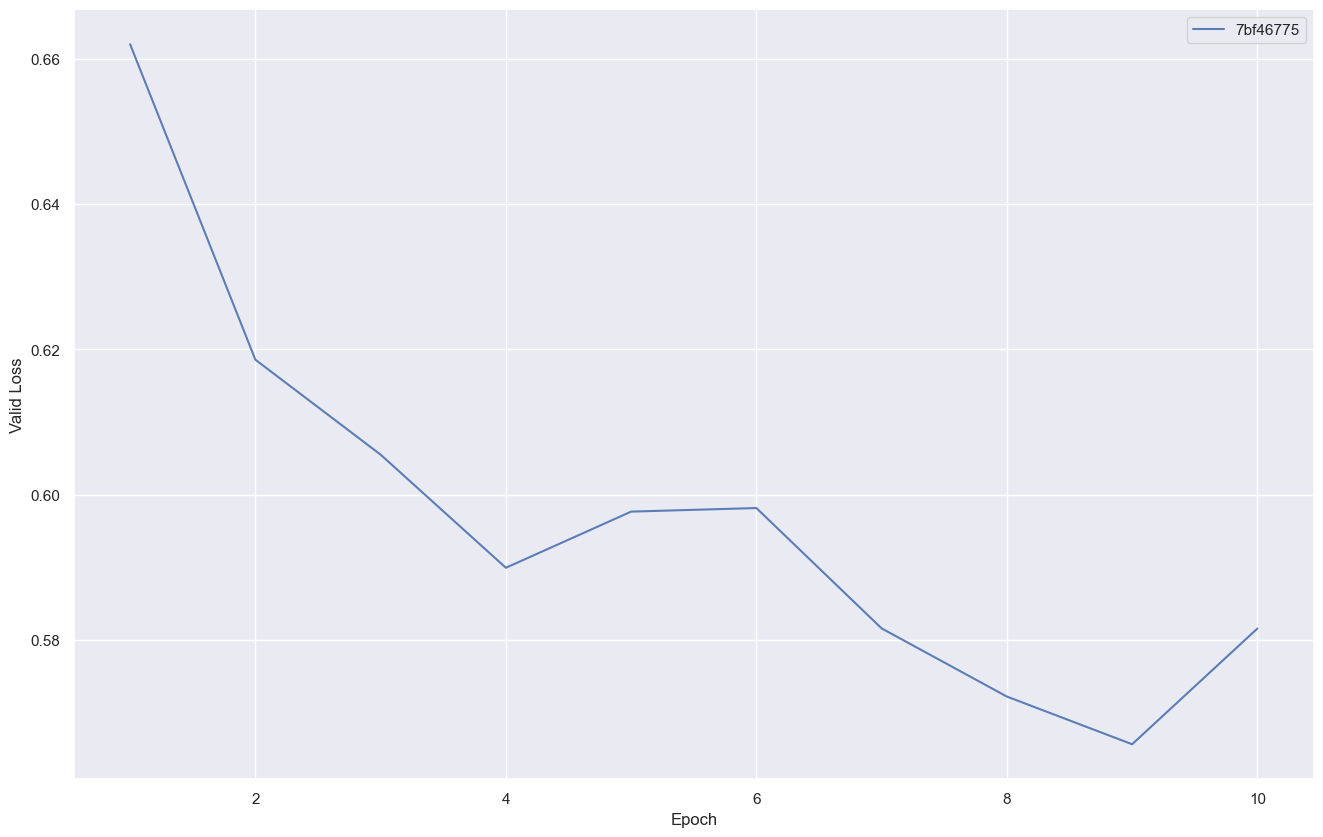

In [27]:
# Plot best trial valid loss

cnn_raytune.plot_trial_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, core_config['model_name'] + '-best')
)

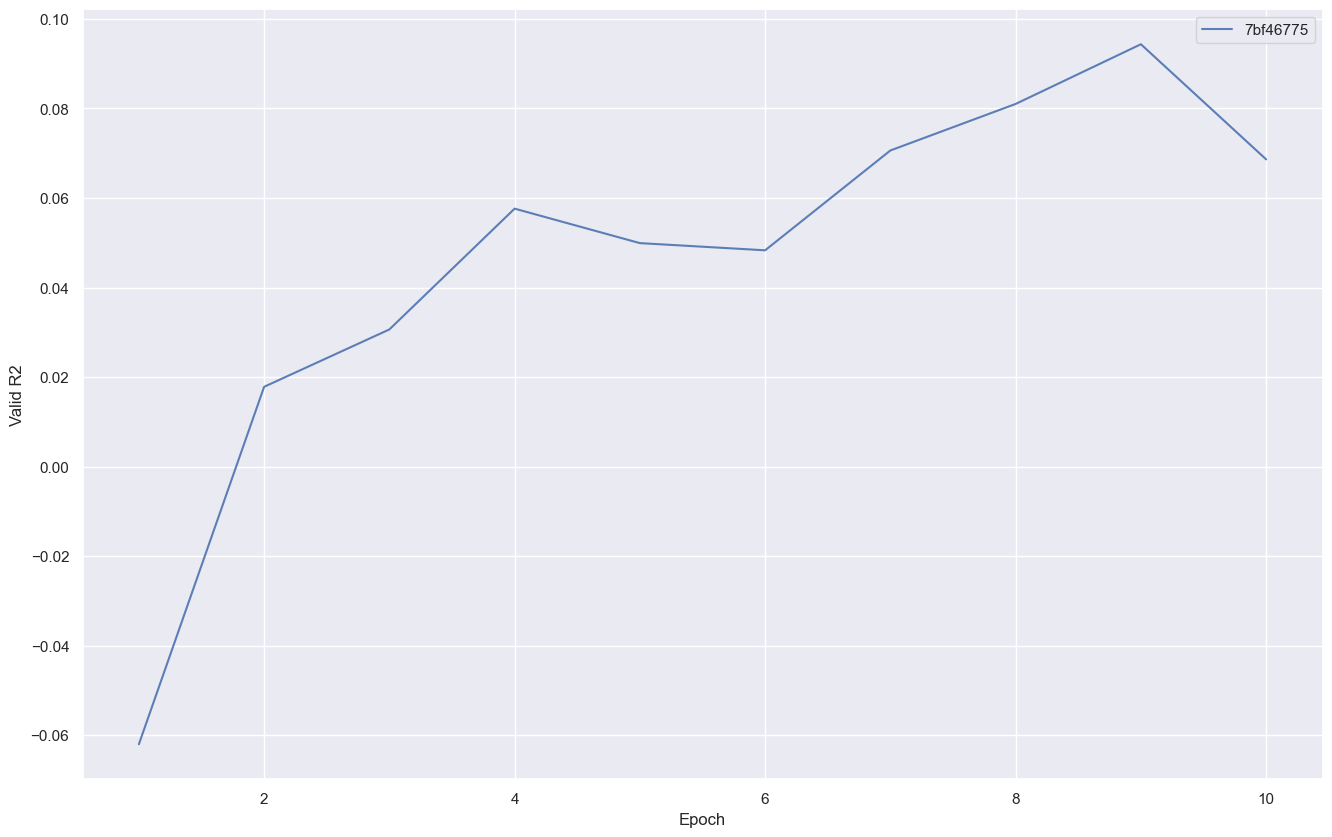

In [28]:
# Plot best trial valid r2

cnn_raytune.plot_trial_r2(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, core_config['model_name'] + '-best')
)

### 2.4.3 Worst

In [29]:
# Display worst trial

worst = report.get_best_result(metric = 'valid_loss', mode = 'max')

print('Worst metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(worst.metrics['valid_loss'], worst.metrics['valid_r2']))
print('Worst config : ')
print(json.dumps(worst.config, indent = '\t'))

Worst metric : loss =  2.62452 r2 = -3.14882
Worst config : 
{
	"dataset/batch_size": 64,
	"optimizer/name": "adam",
	"optimizer/lr": 1.0003033708130141e-05,
	"optimizer/decay": 0.07793231904011638,
	"optimizer/momentum": 0.5602145773922614,
	"scheduler/name": "plateau",
	"scheduler/plateau/factor": 0.2610861906666869,
	"scheduler/plateau/patience": 13,
	"scheduler/linear/factor": 0.0577697325352013,
	"scheduler/step/factor": 0.36676047382113375,
	"scheduler/step/patience": 15,
	"scheduler/exponential/factor": 0.9783641278293967,
	"model/dropout": 0.33,
	"model/conv1/filters": 128,
	"model/conv1/kernel": 41,
	"model/conv1/padding": "none",
	"model/conv1/dilation": 1,
	"model/conv2/filters": 64,
	"model/conv2/kernel": 31,
	"model/conv2/padding": "none",
	"model/conv2/dilation": 1,
	"model/conv3/filters": 32,
	"model/conv3/kernel": 11,
	"model/conv3/padding": "none",
	"model/conv3/dilation": 1,
	"model/maxpool1/kernel": 3,
	"model/maxpool1/padding": "same",
	"model/maxpool2/kernel": 5,
	

In [30]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(worst.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,19bf5233,f799d9006037484683a31bcfb9a09596,96.271,1,2.609,-3.107,1.393,3.153
1,19bf5233,f799d9006037484683a31bcfb9a09596,153.148,2,2.625,-3.149,1.399,2.676


## 2.5 Save

In [31]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, core_config['model_name'] + '-report.csv')
)